In [1]:
from glob import glob
from tqdm import tqdm

import os 

import matplotlib.pyplot as plt

import numpy as np

# cross-validaion and evaluation tools
from sklearn.metrics import classification_report

# model development and data preparation
import torch
import torchvision

# extra modeling and data reading tools from pytorch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image

from torchvision import transforms as t
from torchvision.transforms import functional as F

from adaptable_neural_network.simple_cnn import SimpleCNN

import PIL

torch.backends.cudnn.benchmark = True

In [3]:
data_pth = '../datasets/PetImages'
cats_dir = data_pth + '/Cat'
dogs_dir = data_pth + '/Dog'

In [4]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    """ Shows random N samples from the dataset """
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # then it is in the form (x, y)
            sample, label = sample
            if isinstance(label, torch.TensorType):
                label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        axs[0, i].imshow(F.to_pil_image(sample))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

def random_split_ratio(dataset, test_size=.2, random_state=None):
    L = len(dataset)
    n_second = int(L*test_size)
    n_first = L - n_second
    if random_state:
        first_split, second_split = random_split(dataset, lengths=[n_first, n_second], generator=torch.Generator().manual_seed(random_state))
    else:
        first_split, second_split = random_split(dataset, lengths=[n_first, n_second])

    return first_split, second_split

def verify_image(fp):
    try:
        PIL.Image.open(fp).verify()
        return True
    except:
        return False

In [5]:
def train(model, loss_fn, 
          train_loader, val_loader,return_model=False,
          device='cpu', lr_adjuster=None, epochs=10):
    
    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    
    training_losses = []
    validation_losses = [] 
    
    # initialize the model
    optimizer = get_optimizer(model)

    # pass the model to the given device
    model.to(device)

    print("Number of samples")
    print("Training:", n_train)
    print('Validation:', n_val)
    for epoch in range(epochs):
        # define running losses
        epoch_training_running_loss = 0
        epoch_val_running_loss = 0

        if lr_adjuster:
            lr = lr_adjuster(optimizer, epoch)
        
        bar = tqdm(enumerate(train_loader), total=n_train//train_loader.batch_size)
        # loop through every batch in the training loader
        for batch_idx, (x_batch, y_batch) in bar:
            # pass the batches to given device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # set the gradients to 0 beforehand
            # it can also be written after `optimizer.step()`, just a preference.
            outs = model(x_batch)
            loss = loss_fn(outs, y_batch)
            # calculate the gradients and apply an optimization step
            loss.backward() 
            optimizer.step()
            optimizer.zero_grad()

            # we can use `.item()` method to read the loss value
            # since the loss function automatically calculates the loss by averaging the input size,
            # we will multiply it with the batch size to add it
            # then we can average it by the whole dataset size
            # note: it is also possible to average the loss by the number of batches at the end of the epoch (without multiplying with x_batch.size(0))
            # but this approach is more straightforward.
            epoch_training_running_loss += (loss.item() * x_batch.size(0))

        with torch.no_grad():
            model.eval()
            vbar = tqdm(val_loader, total=n_val//val_loader.batch_size)
            for x_batch, y_batch in vbar:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                outs = model(x_batch)
                loss = loss_fn(outs, y_batch)
                    
                epoch_val_running_loss += (loss.item() * x_batch.size(0))
            model.train()

        average_training_loss = epoch_training_running_loss / n_train
        average_validation_loss = epoch_val_running_loss / n_val

        training_losses.append(average_training_loss)
        validation_losses.append(average_validation_loss)
        
        if lr_adjuster:
            print(f"epoch {epoch+1}/{epochs}, lr={lr} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}")
        else:
            print(f"epoch {epoch+1}/{epochs} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}")

            
    # return the training and validtion losses, also return the model if return_model is True
    if return_model:
        return training_losses, validation_losses, model
    else:
        return training_losses, validation_losses

In [6]:
class SubsetTransforms(Dataset):
    def __init__(self, subset, transforms):
        self.subset = subset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transforms(x), y

    def __len__(self):
        return len(self.subset)

In [7]:
transform = t.Compose([
    t.Resize((128, 128)),
    t.ToTensor(),
    t.ConvertImageDtype(torch.float32)
])

training_transform = t.Compose([
    t.Resize((128, 128)),
    t.RandomRotation([0,45]),
    t.ToTensor(),
    t.ConvertImageDtype(torch.float32)
])

dataset = torchvision.datasets.ImageFolder(data_pth, is_valid_file=verify_image)

training_dataset, test_dataset = random_split_ratio(dataset, random_state=42)
training_dataset, validation_dataset = random_split_ratio(training_dataset, random_state=42)

training_dataset = SubsetTransforms(training_dataset, training_transform)
test_dataset = SubsetTransforms(test_dataset, transform)
validation_dataset = SubsetTransforms(validation_dataset, transform)

/home/shuai/.pyenv/versions/3.7.5/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


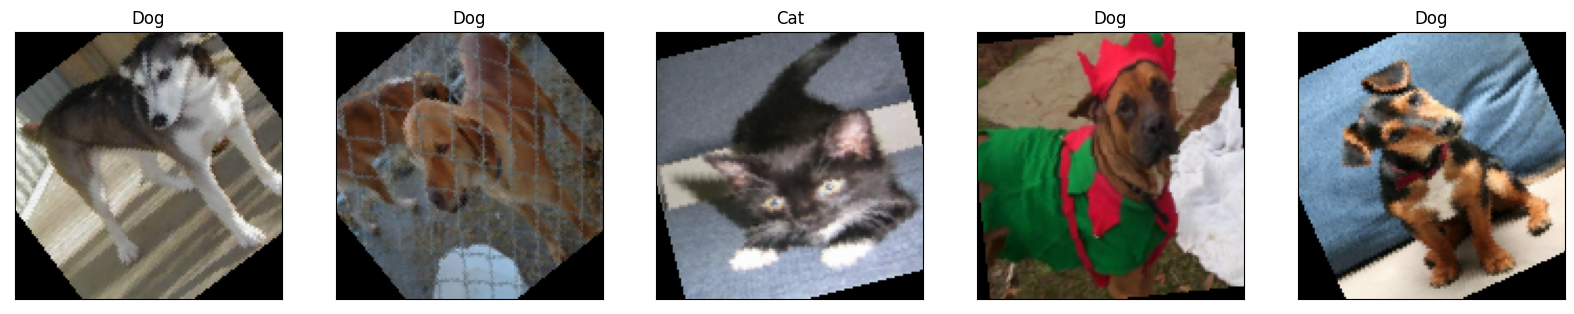

In [8]:
labels_to_idx = {"Dog":1, "Cat":0}
idx_to_labels = {0: "Cat", 1: "Dog"}

show(training_dataset, labels=idx_to_labels)

In [9]:
model = SimpleCNN(2)
loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=2e-4, betas=(0.9, 0.999), eps=1e-8)
    return optimizer

In [11]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 3e-5
    
    elif epoch < 5:
        lr = 1e-4
    
    elif epoch < 8:
        lr = 1e-5
    else:
        lr = 6e-6
        
    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr

train_loader = DataLoader(training_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

training_loss, validation_loss, model = train(model, loss_fn, train_loader, val_loader, 
                                              lr_adjuster=adjust_lr, return_model=True, device=device, epochs=10)

Number of samples
Training: 16000
Validation: 3999


63it [02:53,  2.75s/it]                                                                                  
16it [00:32,  2.06s/it]                                                                                  


epoch 1/10, lr=3e-05 | avg. training loss: 0.691, avg. validation loss: 0.686


63it [00:36,  1.74it/s]                                                                                  
16it [00:08,  1.99it/s]                                                                                  


epoch 2/10, lr=0.0001 | avg. training loss: 0.671, avg. validation loss: 0.645


63it [00:36,  1.73it/s]                                                                                  
16it [00:07,  2.00it/s]                                                                                  


epoch 3/10, lr=0.0001 | avg. training loss: 0.625, avg. validation loss: 0.611


63it [00:36,  1.74it/s]                                                                                  
16it [00:07,  2.01it/s]                                                                                  


epoch 4/10, lr=0.0001 | avg. training loss: 0.605, avg. validation loss: 0.599


63it [00:35,  1.75it/s]                                                                                  
16it [00:08,  2.00it/s]                                                                                  


epoch 5/10, lr=0.0001 | avg. training loss: 0.594, avg. validation loss: 0.590


63it [00:37,  1.68it/s]                                                                                  
16it [00:08,  2.00it/s]                                                                                  


epoch 6/10, lr=1e-05 | avg. training loss: 0.585, avg. validation loss: 0.589


63it [00:35,  1.75it/s]                                                                                  
16it [00:08,  2.00it/s]                                                                                  


epoch 7/10, lr=1e-05 | avg. training loss: 0.585, avg. validation loss: 0.588


63it [00:36,  1.75it/s]                                                                                  
16it [00:07,  2.01it/s]                                                                                  


epoch 8/10, lr=1e-05 | avg. training loss: 0.584, avg. validation loss: 0.587


63it [00:36,  1.74it/s]                                                                                  
16it [00:08,  1.99it/s]                                                                                  


epoch 9/10, lr=6e-06 | avg. training loss: 0.582, avg. validation loss: 0.587


63it [00:36,  1.75it/s]                                                                                  
16it [00:08,  2.00it/s]                                                                                  

epoch 10/10, lr=6e-06 | avg. training loss: 0.582, avg. validation loss: 0.586


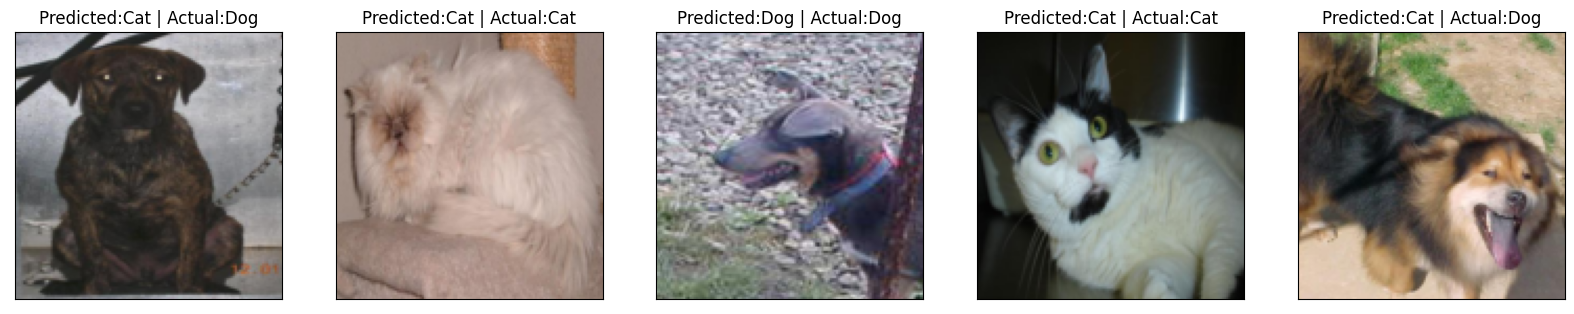

In [12]:
N=5
random_indices = np.random.randint(0, len(test_dataset)-1, N)
random_samples = [test_dataset[i] for i in random_indices]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,20))

for i in range(N):
    sample = random_samples[i]
    image, label = sample
    category = idx_to_labels[label]
    
    input_image = image.unsqueeze(0).to(device)
    model_output = model(input_image)
    prediction = torch.argmax(torch.softmax(model_output, -1)).item()
    predicted_category = idx_to_labels[prediction]
    
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    axs[i].set_title(f'Predicted:{predicted_category} | Actual:{category}')
plt.show()